In [1]:
#periodo_filtro=""
#periodo_filtro="and substring(pro.periodo,0,5) not in('2013','2018')"
periodo_filtro="and substring(pro.periodo,0,5)  in('2018')"
#columnas razonamiento cuantitativo
columnas=['pro.punt_ingles_escala','s11.punt_ingles']

In [2]:
sql=("SELECT pro.estu_consecutivo AS pro,"+
    "s11.estu_consecutivo AS c11,"+
    columnas[0]+" as pruebaEcaes,"+
    columnas[1]+" as prueba11,"+
    "pro.periodo AS periodo_ecaes,"+
    "s11.periodo AS periodo_11"+
   " FROM proyecto.va_saber_pro pro"+
     " JOIN proyecto.va_cruces c ON pro.estu_consecutivo = c.estu_consecutivo_pro"+
     " JOIN proyecto.va_saber_11 s11 ON s11.estu_consecutivo = c.estu_consecutivo_11"+
  " WHERE pro.departamento_programa = 'NARIÑO'::text "+
  " AND pro.nombre_institucion ~~* 'UNIVERSIDAD DE NARIÑO-PASTO'::text AND pro.programa = 'INGENIERIA DE SISTEMAS'::text "
     +periodo_filtro+
 " ORDER BY pro.periodo;")

In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, event
from urllib.parse import quote_plus

In [4]:
# follows django database settings format, replace with your own settings
DATABASES = {
       'produccion':{
        'NAME': 'proyecto_va',
        'USER': 'postgres',
        'PASSWORD': 'Grias*20',
        'HOST': '10.10.10.117',
        'PORT': 5432,
    }

}

db_produccion=DATABASES['produccion']
prod_engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db_produccion['USER'],
    password = db_produccion['PASSWORD'],
    host = db_produccion['HOST'],
    port = db_produccion['PORT'],
    database = db_produccion['NAME'],
    fast_executemany=True
)

# create sqlalchemy engine
prod= create_engine(prod_engine_string)

In [5]:
df=pd.read_sql_query(sql,prod)
prod.dispose()
df.head()

pro                 c11  pruebaecaes  prueba11 periodo_ecaes  \
0  EK201830019002  SABER1120102036050    44.666667     38.53         20183   
1  EK201830018873  SABER1120081026349    46.666667     41.60         20183   
2  EK201830019897  SABER1120081132046    57.666667     49.51         20183   
3  EK201830022704  SABER1120082141077    42.333333     28.24         20183   
4  EK201830046385  SABER1120102581686    56.000000     45.84         20183   

  periodo_11  
0      20102  
1      20081  
2      20081  
3      20082  
4      20102

In [6]:
#Formula zscore
def z_score(datos):
    z=(datos-datos.mean())/datos.std()
    return z

In [7]:
#Calcular el rendimiento por inidividuo
df['pruebaecaes_rend']=df['pruebaecaes']/df['pruebaecaes'].max()
df['prueba11_rend']=df['prueba11']/df['prueba11'].max()

In [8]:
#aplicar transformación zscore
df['pruebaecaes_norm']=z_score(df['pruebaecaes_rend'])
df['prueba11_norm']=z_score(df['prueba11_rend'])

In [9]:
df.describe()

pruebaecaes  prueba11  pruebaecaes_rend  prueba11_rend  \
count    30.000000  30.00000         30.000000      30.000000   
mean     51.500000  49.68900          0.708716       0.645312   
std       9.101703  11.67817          0.125253       0.151665   
min      35.333333  28.24000          0.486239       0.366753   
25%      44.416667  43.00000          0.611239       0.558442   
50%      51.000000  48.25500          0.701835       0.626688   
75%      56.250000  55.57750          0.774083       0.721786   
max      72.666667  77.00000          1.000000       1.000000   

       pruebaecaes_norm  prueba11_norm  
count      3.000000e+01   3.000000e+01  
mean      -1.397031e-15   1.554312e-16  
std        1.000000e+00   1.000000e+00  
min       -1.776224e+00  -1.836675e+00  
25%       -7.782426e-01  -5.727781e-01  
50%       -5.493477e-02  -1.227932e-01  
75%        5.218804e-01   5.042314e-01  
max        2.325572e+00   2.338637e+00

In [10]:
#diferencia
df['va_norm']=df.pruebaecaes-df.prueba11
df['va']=df.pruebaecaes_rend-df.prueba11_rend

In [11]:
df.describe()

pruebaecaes  prueba11  pruebaecaes_rend  prueba11_rend  \
count    30.000000  30.00000         30.000000      30.000000   
mean     51.500000  49.68900          0.708716       0.645312   
std       9.101703  11.67817          0.125253       0.151665   
min      35.333333  28.24000          0.486239       0.366753   
25%      44.416667  43.00000          0.611239       0.558442   
50%      51.000000  48.25500          0.701835       0.626688   
75%      56.250000  55.57750          0.774083       0.721786   
max      72.666667  77.00000          1.000000       1.000000   

       pruebaecaes_norm  prueba11_norm    va_norm         va  
count      3.000000e+01   3.000000e+01  30.000000  30.000000  
mean      -1.397031e-15   1.554312e-16   1.811000   0.063404  
std        1.000000e+00   1.000000e+00   7.390711   0.096298  
min       -1.776224e+00  -1.836675e+00 -11.000000  -0.101037  
25%       -7.782426e-01  -5.727781e-01  -3.132500   0.002404  
50%       -5.493477e-02  -1.227932e-01   0.546667   0.042863  
75%        5.218804e-01   5.042314e-01   6.916667   0.132551  
max        2.325572e+00   2.338637e+00  20.333333   0.306148

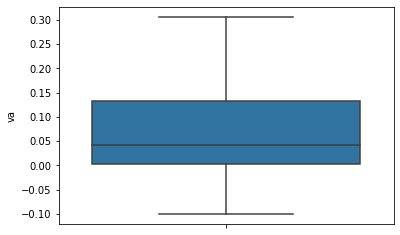

In [12]:
# library & dataset
#!pip install seaborn
import seaborn as sns

# Make boxplot for one group only
sns.boxplot( y=df["va"] )
#sns.plt.show()
df_aux=df.copy()

# Filtrar Ouliers

In [13]:
di=df_aux["va"].quantile(0.75)-df_aux["va"].quantile(0.25)

q3=df_aux["va"].quantile(0.75)
q3=q3+1.5*di

q1=df_aux["va"].quantile(0.25)
q1=q1-(1.5*di)

print(len(df_aux[df_aux.va>=q3]))
print(len(df_aux[df_aux.va<=q1]))

df_aux=df_aux[df_aux.va<q3]
df_aux=df_aux[df_aux.va>q1]

#len(df_aux[df_aux.va<df_aux["va"].quantile(0.25)*3*di])

0
0


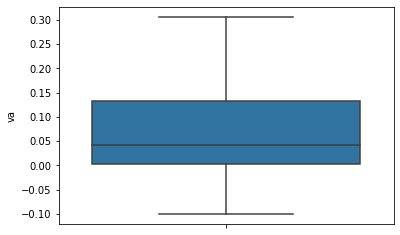

In [14]:
# library & dataset
#!pip install seaborn
import seaborn as sns


 
# Make boxplot for one group only
sns.boxplot(y=df_aux["va"] )
#sns.plt.show()



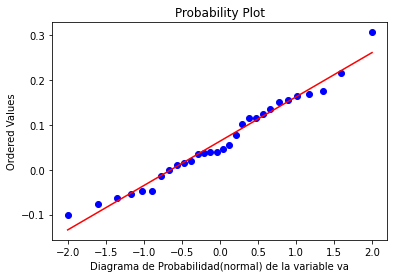

In [15]:
import matplotlib.pyplot as plt
from scipy import stats
def normalidad_variable_numerica(col):
    stats.probplot(df_aux[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()
normalidad_variable_numerica('va')

# D’Agostino and Pearson’s

In [16]:
#H0 es normal
#H1 no es normal

columnas_numericas = df_aux.select_dtypes(['int', 'float64']).columns
for num_col in columnas_numericas:
    _, pval = stats.normaltest(df_aux[num_col])
    #print(pval)
    if(pval < 0.05):
        print("Rechaza h0: Columna {} no sigue una distribución normal".format(num_col), pval)
    else:
        print("No Rechaza ho: Columna {}  sigue una distribución normal".format(num_col),pval)

No Rechaza ho: Columna pruebaecaes  sigue una distribución normal 0.692559072589406
No Rechaza ho: Columna prueba11  sigue una distribución normal 0.3933295007548815
No Rechaza ho: Columna pruebaecaes_rend  sigue una distribución normal 0.6925590725894123
No Rechaza ho: Columna prueba11_rend  sigue una distribución normal 0.39332950075488055
No Rechaza ho: Columna pruebaecaes_norm  sigue una distribución normal 0.6925590725894069
No Rechaza ho: Columna prueba11_norm  sigue una distribución normal 0.3933295007548812
No Rechaza ho: Columna va_norm  sigue una distribución normal 0.6423263101996262
No Rechaza ho: Columna va  sigue una distribución normal 0.647739696404028


In [17]:
#Ho es normal
#H1 no es normal


#!pip install plotly
from scipy.stats import normaltest
#import plotly.plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

import numpy as np
import pandas as pd
import scipy

stat, p = normaltest(df_aux.va)

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0) No rechaza H0 Es normal'
else:
    msg = 'Sample does not look Gaussian (reject H0) No es Normal'

print(msg)
p

Sample looks Gaussian (fail to reject H0) No rechaza H0 Es normal


0.647739696404028

In [449]:
#Ho es normal
#H1 no es normal
#import numpy as np
#from scipy.stats import kstest

#pvalue=kstest(df_aux.va,'norm').pvalue
#if pvalue<0.05:
#    print("Rechaza h0: Columna {} no sigue una distribución normal".format(num_col), pvalue)
#else:
#    print("No Rechaza ho: Columna {}  sigue una distribución normal".format(num_col),pvalue)

# Shapiro-Wilk Test

In [18]:
#Ho Es normal
#H1 No es normal

from scipy.stats import shapiro
stat, p = shapiro(df_aux.va)

# interpret
alpha = 0.05
if p < alpha:
    msg = 'rechaza H0: no es normal'
else:
    msg = 'No rechaza H0: es normal'
    
print(msg)
print("probabilidad:",p)
print("valor stat:",stat)

No rechaza H0: es normal
probabilidad: 0.6415470838546753
valor stat: 0.9735989570617676


# Anderson-Darling Test

In [19]:
#H0: es normal
#H1: no es

from scipy.stats import anderson
import plotly.graph_objs as go

result = anderson(df_aux.va)
stat = round(result.statistic, 4)

p = 0
result_mat = []
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        msg = '(fail to reject H0) Es Normal'
    else:
        msg = '(reject H0) No es Normal'
    result_mat.append([len(df_aux.va), stat, sl, cv, msg])

trace = go.Table(
    header=dict(values=['<b>Sample Size</b>', '<b>Statistic</b>', '<b>Significance Level</b>', '<b>Critical Value</b>', '<b>Comment</b>'],
                line = dict(width=0),
                fill = dict(color='rgba(42,63,95,0.8)'),
                align = 'center',
                font = dict(
                    color = '#ffffff',
                    size = 12
                )),
    cells=dict(values=np.array(result_mat).T,
               line = dict(width=0),
               fill = dict(color=[['#EBF0F8', '#ffffff', '#EBF0F8', '#ffffff', '#EBF0F8']]),
               align = 'center',
               height = 40),
    columnwidth=[0.3, 0.25, 0.3, 0.25, 0.5])
layout = dict(
    height=300,
    margin=dict(
        l=5,
        r=5,
        t=30,
        b=0
    )
)
data = [trace]
andar_table = dict(data=data, layout=layout)

result_mat

[[30, 0.2724, 15.0, 0.521, '(fail to reject H0) Es Normal'],
 [30, 0.2724, 10.0, 0.593, '(fail to reject H0) Es Normal'],
 [30, 0.2724, 5.0, 0.712, '(fail to reject H0) Es Normal'],
 [30, 0.2724, 2.5, 0.83, '(fail to reject H0) Es Normal'],
 [30, 0.2724, 1.0, 0.988, '(fail to reject H0) Es Normal']]

# Test Hipotesis

In [20]:
#muestreo aleotorio 
import math 

def tobs(datos,tam_muestra):
    df_aux_t=datos.sample(n=tam_muestra)
 
    d=df_aux_t['va'].mean()
    n=df_aux_t['va'].count()
    sd=df_aux_t['va'].std()

    tObs=(d-0)/(sd/math.sqrt(n))
    return (tObs,n,d,sd)

resultado=tobs(df_aux,df_aux.va.count())
#resultado=tobs(df_aux,100)
resultado

#HO Md<=0 No aporta 
#H1 Md>0  aporta

(3.606265979762059, 30, 0.06340390801858689, 0.09629836193628195)